# Projected Coral Bleaching
Percentage of total reef area situated in waters where coral bleaching conditions are projected to exceed a threshold of frequency, aggregated by decade.

_Author: Peter Kerins_  
_Created: 27 Jan 2021_  
_Updated: 22 Apr 2021_
_Environment: jupyterlab_  

## Style
- Original
    - Vega chart
    - Time series
    - Vertical bar chart
    - Value showing fraction of reef area beyond threshold
    - Double bars, one for each bleaching frequency
- Revision
    - Vega chart
    - Time series
    - Vertical bar chart
    - Value is fraction beyond each threshold, for each threshold
    - Single stacked, normalized bar per decade

### Data
[ocn.calcs.003 Coral Reef Projected Bleaching Areas by MEOW per Decade](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade)

Calculations based on:  
- [bio.004.rw2 Coral Reef Locations](https://resourcewatch.carto.com/u/wri-rw/tables/bio_004a_coral_reef_locations_edit/)  
- [ocn.010.rw0 Projected Coral Bleaching](https://code.earthengine.google.com/?asset=projects/resource-watch-gee/ocn_010_projected_coral_bleaching)

[Google Earth Engine calculation script](https://code.earthengine.google.com/5fa796302af6a63824bcd9efb62f2bde?noload=true)

## Preparation

In [2]:
import json
from vega import Vega
from IPython.display import display

In [3]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [4]:
widget_width = 400
widget_height = 300

# Original version
Side-by-side double bars for each decade, corresponding to the two frequency thresholds

## Global specification  

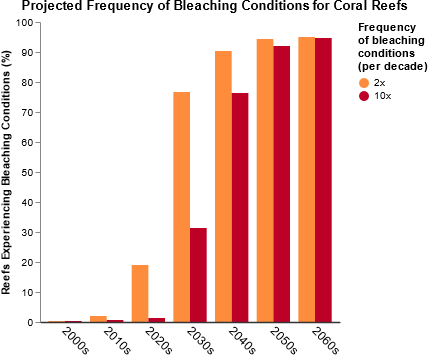

In [5]:
spec=json.loads("""
{
  "width": 300,
  "height": 300,
  "autosize": {"type": "pad", "resize": true, "contains": "padding"},
  "title": "Projected Frequency of Bleaching Conditions for Coral Reefs",
  "signals": [
    {
      "name": "hover",
      "value": null,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT decade_start, frequency, SUM(bleaching_area) AS bleaching_area, SUM(total_area) AS total_area, SUM(bleaching_area)/SUM(total_area) AS bleaching_fraction, SUM(SUM(bleaching_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_running FROM (SELECT cartodb_id, '2x' AS frequency, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_2x, _2010s_2x, _2020s_2x, _2030s_2x, _2040s_2x, _2050s_2x, _2060s_2x, _2070s_2x, _2080s_2x, _2090s_2x]) AS bleaching_area, reefarea AS total_area FROM ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade) AS decadal_data GROUP BY decade_start, frequency UNION ALL SELECT decade_start, frequency, SUM(bleaching_area) AS bleaching_area, SUM(total_area) AS total_area, SUM(bleaching_area)/SUM(total_area) AS bleaching_fraction, SUM(SUM(bleaching_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_running FROM(SELECT cartodb_id, '10x' AS frequency, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_10x, _2010s_10x, _2020s_10x, _2030s_10x, _2040s_10x, _2050s_10x, _2060s_10x, _2070s_10x, _2080s_10x, _2090s_10x]) AS bleaching_area, reefarea AS total_area FROM ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade) AS decadal_data GROUP BY decade_start, frequency ORDER BY decade_start ASC, frequency DESC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "formula",
          "as": "bleaching_percentage",
          "expr": "datum.bleaching_fraction * 100.0"
        },
        {
          "type": "formula",
          "as": "bleaching_percentage_running",
          "expr": "datum.bleaching_fraction_running * 100.0"
        },
        {"type": "filter", "expr": "datum.decade_start < 2070"}
      ]
    }
  ],
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "decade_start"},
      "range": "width",
      "padding": 0.2
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {"data": "table", "field": "bleaching_percentage_running"},
      "range": "height",
      "round": true,
      "zero": true,
      "nice": true
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "table", "field": "frequency"},
      "range": ["#fd8d3c", "#bd0026"]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Reefs Experiencing Bleaching Conditions (%)"
    },
    {
      "orient": "bottom",
      "scale": "xscale",
      "tickSize": 0,
      "labelPadding": 4,
      "zindex": 1,
      "encode": {
        "labels": {
          "interactive": true,
          "update": {
            "text": {"signal": "datum.value + 's'"},
            "fill": {"value": "black"},
            "angle": {"value": 45},
            "fontSize": {"value": 12},
            "align": {"value": "left"},
            "baseline": {"value": "middle"},
            "dy": {"value": 2},
            "dx": {"value": 1}
          },
          "hover": {"fill": {"value": "firebrick"}}
        },
        "domain": {
          "update": {"stroke": {"value": "#333"}, "strokeWidth": {"value": 1.5}}
        }
      }
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {
        "facet": {"data": "table", "name": "facet", "groupby": "decade_start"}
      },
      "encode": {"enter": {"x": {"scale": "xscale", "field": "decade_start"}}},
      "signals": [{"name": "width", "update": "bandwidth('xscale')"}],
      "scales": [
        {
          "name": "pos",
          "type": "band",
          "range": "width",
          "domain": {"data": "facet", "field": "frequency"}
        }
      ],
      "marks": [
        {
          "name": "bars",
          "from": {"data": "facet"},
          "type": "rect",
          "encode": {
            "enter": {
              "x": {"scale": "pos", "field": "frequency"},
              "width": {"scale": "pos", "band": 1},
              "y": {"scale": "yscale", "field": "bleaching_percentage_running"},
              "y2": {"scale": "yscale", "value": 0},
              "fill": {"scale": "color", "field": "frequency"},
              "tooltip": {
                "signal": "{title:'Coral experiencing bleaching ' + datum.frequency + '/decade in ' + datum.decade_start + 's', 'Fraction of global reef area':format(datum.bleaching_fraction_running,'.1%')}"
              }
            },
            "hover": {"fillOpacity": {"value": 0.5}},
            "update": {"fillOpacity": {"value": 1}}
          }
        }
      ]
    }
  ],
  "legends": [
    {
      "title": [
        "Frequency",
        "of bleaching",
        "conditions",
        "(per decade)"
      ],
      "fill": "color",
      "orient": "right"
    }
  ]
}
""")
vegaview=dict(spec)
Vega(vegaview)

### Resource Watch specification
API ID: <GID>  
https://resourcewatch.org/embed/widget/92dbd486-14dd-401f-a743-e05eab210a37<GID>

### Script to pass modified specification to RW via API
Based on [template in data-team-tool](https://github.com/resource-watch/data-team-tools/blob/6bf21e42d724b5f72060dd2f833864df8acad09e/map_embed_widget/embed_widget.py)

In [3]:
# import LMIPy as lmi
import os
import json
import requests
import dotenv
dotenv.load_dotenv(os.path.abspath(os.getenv('RW_ENV')))

True

In [7]:
# input widget API ID for the empty advanced widget you have created and want to overwrite
dataset_id = '9748a184-cf87-4363-bf81-2bf3030e2e53'
widget_to_overwrite = '92dbd486-14dd-401f-a743-e05eab210a37'

# replace the empty dictionary with the code from the vega editor
# replace true with True and null with None
vega = {
  "width": 300,
  "height": 300,
  "autosize": {"type": "pad", "resize": True, "contains": "padding"},
  "signals": [
    {
      "name": "hover",
      "value": None,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT decade_start, frequency, SUM(bleaching_area) AS bleaching_area, SUM(total_area) AS total_area, SUM(bleaching_area)/SUM(total_area) AS bleaching_fraction, SUM(SUM(bleaching_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_running FROM (SELECT cartodb_id, '2x' AS frequency, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_2x, _2010s_2x, _2020s_2x, _2030s_2x, _2040s_2x, _2050s_2x, _2060s_2x, _2070s_2x, _2080s_2x, _2090s_2x]) AS bleaching_area, reefarea AS total_area FROM ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade) AS decadal_data GROUP BY decade_start, frequency UNION ALL SELECT decade_start, frequency, SUM(bleaching_area) AS bleaching_area, SUM(total_area) AS total_area, SUM(bleaching_area)/SUM(total_area) AS bleaching_fraction, SUM(SUM(bleaching_area)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_running FROM(SELECT cartodb_id, '10x' AS frequency, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_10x, _2010s_10x, _2020s_10x, _2030s_10x, _2040s_10x, _2050s_10x, _2060s_10x, _2070s_10x, _2080s_10x, _2090s_10x]) AS bleaching_area, reefarea AS total_area FROM ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade) AS decadal_data GROUP BY decade_start, frequency ORDER BY decade_start ASC, frequency DESC",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "formula",
          "as": "bleaching_percentage",
          "expr": "datum.bleaching_fraction * 100.0"
        },
        {
          "type": "formula",
          "as": "bleaching_percentage_running",
          "expr": "datum.bleaching_fraction_running * 100.0"
        },
        {"type": "filter", "expr": "datum.decade_start < 2070"}
      ]
    }
  ],
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "decade_start"},
      "range": "width",
      "padding": 0.2
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {"data": "table", "field": "bleaching_percentage_running"},
      "range": "height",
      "round": True,
      "zero": True,
      "nice": True
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "table", "field": "frequency"},
      "range": ["#fd8d3c", "#bd0026"]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Reefs Experiencing Bleaching Conditions (%)"
    },
    {
      "orient": "bottom",
      "scale": "xscale",
      "tickSize": 0,
      "labelPadding": 4,
      "zindex": 1,
      "encode": {
        "labels": {
          "interactive": True,
          "update": {
            "text": {"signal": "datum.value + 's'"},
            "fill": {"value": "black"},
            "angle": {"value": 45},
            "fontSize": {"value": 12},
            "align": {"value": "left"},
            "baseline": {"value": "middle"},
            "dy": {"value": 2},
            "dx": {"value": 1}
          },
          "hover": {"fill": {"value": "firebrick"}}
        },
        "domain": {
          "update": {"stroke": {"value": "#333"}, "strokeWidth": {"value": 1.5}}
        }
      }
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {
        "facet": {"data": "table", "name": "facet", "groupby": "decade_start"}
      },
      "encode": {"enter": {"x": {"scale": "xscale", "field": "decade_start"}}},
      "signals": [{"name": "width", "update": "bandwidth('xscale')"}],
      "scales": [
        {
          "name": "pos",
          "type": "band",
          "range": "width",
          "domain": {"data": "facet", "field": "frequency"}
        }
      ],
      "marks": [
        {
          "name": "bars",
          "from": {"data": "facet"},
          "type": "rect",
          "encode": {
            "enter": {
              "x": {"scale": "pos", "field": "frequency"},
              "width": {"scale": "pos", "band": 1},
              "y": {"scale": "yscale", "field": "bleaching_percentage_running"},
              "y2": {"scale": "yscale", "value": 0},
              "fill": {"scale": "color", "field": "frequency"},
              "tooltip": {
                "signal": "{'Decade':datum.decade_start+'s','Frequency':datum.frequency+'/decade','Reefs':format(datum.bleaching_fraction_running,'.1%')}"
              }
            },
            "hover": {"fillOpacity": {"value": 0.5}},
            "update": {"fillOpacity": {"value": 1}}
          }
        }
      ]
    }
  ],
  "legends": [
    {
      "title": [
        "Frequency",
        "of bleaching",
        "conditions",
        "(per decade)"
      ],
      "fill": "color",
      "orient": "right"
    }
  ]
}


# create payload to send to API
# you must edit the interaction_config
payload = {
    "widgetConfig": {
        "schema": "https://vega.github.io/schema/vega/v5.json",
        **vega,
        "interaction_config": [
          {
          }
        ],
      }
    }

# load in API credentials
API_TOKEN = os.getenv('RW_API_KEY')
headers = {
'Content-Type': 'application/json',
'Authorization': 'Bearer '+API_TOKEN, 
}

# load the widget we are going to overwrite
# option 1: LMIPY
#widget = lmi.Widget(widget_to_overwrite)
# option 2: requests
url = f'http://api.resourcewatch.org/v1/dataset/{dataset_id}/widget/{widget_to_overwrite}'

# Update the widget
# option 1: LMIPY
#widget = widget.update(update_params=payload, token=API_TOKEN)
# option 2: requests
r = requests.patch(url = url, json = payload, headers = headers)
print(r)

<Response [200]>


---

# Revised version
Single stacked, normalized bar for each decade, with segments for area below both thresholds and below neither.

## Global

### SQL

```sql
SELECT lvl1.*,
1-bleaching_fraction_2x_running AS fraction_none,
bleaching_fraction_2x_running-bleaching_fraction_10x_running AS fraction_2x,
bleaching_fraction_10x_running AS fraction_10x
FROM (
  SELECT decade_start, SUM(total_area) AS total_area, SUM(bleaching_area_2x) AS bleaching_area_2x, SUM(bleaching_area_10x) AS bleaching_area_10x,
  SUM(bleaching_area_2x)/SUM(total_area) AS bleaching_fraction_2x, SUM(bleaching_area_10x)/SUM(total_area) AS bleaching_fraction_10x,
  SUM(SUM(bleaching_area_2x)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_2x_running,
  SUM(SUM(bleaching_area_10x)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_10x_running
  FROM (
    SELECT cartodb_id, gcrmn_reg, ecoregion, 
    unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start,
    unnest(array[_2000s_2x, _2010s_2x, _2020s_2x, _2030s_2x, _2040s_2x, _2050s_2x, _2060s_2x, _2070s_2x, _2080s_2x, _2090s_2x]) AS bleaching_area_2x,
    unnest(array[_2000s_10x, _2010s_10x, _2020s_10x, _2030s_10x, _2040s_10x, _2050s_10x, _2060s_10x, _2070s_10x, _2080s_10x, _2090s_10x]) AS bleaching_area_10x,
    reefarea AS total_area
    FROM ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade) AS lvl0
  GROUP BY decade_start
  ORDER BY decade_start ASC) AS lvl1
```

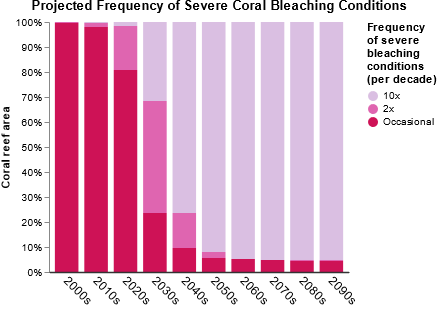

In [6]:
spec=json.loads("""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Projected frequency of bleaching conditions in waters around current (2018) coral reef habitat ",
  "width": 300,
  "height": 250,
  "padding": {
    "left": 0, 
    "top": 0, 
    "right": 0, 
    "bottom": 5
  },
  "autosize": {"type": "pad", "resize": true, "contains": "padding"},
  "signals": [
    {
      "name": "hover",
      "value": null,
      "on": [
        {"events": "@cell:mouseover", "update": "datum"},
        {"events": "@cell:mouseout", "update": "null"}
      ]
    },
    {
      "name": "url_param",
      "description": "Unchanging URL for pulling data; in signal form only as legacy from regional version",
      "update": "'https://wri-rw.carto.com/api/v2/sql?q=SELECT lvl1.*, 1-bleaching_fraction_2x_running AS fraction_none, bleaching_fraction_2x_running-bleaching_fraction_10x_running AS fraction_2x, bleaching_fraction_10x_running AS fraction_10x FROM (SELECT decade_start, SUM(total_area) AS total_area, SUM(bleaching_area_2x) AS bleaching_area_2x, SUM(bleaching_area_10x) AS bleaching_area_10x, SUM(bleaching_area_2x)/SUM(total_area) AS bleaching_fraction_2x, SUM(bleaching_area_10x)/SUM(total_area) AS bleaching_fraction_10x, SUM(SUM(bleaching_area_2x)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_2x_running, SUM(SUM(bleaching_area_10x)/SUM(total_area)) OVER (ORDER BY decade_start) AS bleaching_fraction_10x_running FROM (SELECT cartodb_id, gcrmn_reg, ecoregion, unnest(array[2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]) AS decade_start, unnest(array[_2000s_2x, _2010s_2x, _2020s_2x, _2030s_2x, _2040s_2x, _2050s_2x, _2060s_2x, _2070s_2x, _2080s_2x, _2090s_2x]) AS bleaching_area_2x, unnest(array[_2000s_10x, _2010s_10x, _2020s_10x, _2030s_10x, _2040s_10x, _2050s_10x, _2060s_10x, _2070s_10x, _2080s_10x, _2090s_10x]) AS bleaching_area_10x, reefarea AS total_area FROM ocn_calcs_003_reef_projected_bleaching_area_by_meow_per_decade) AS lvl0 GROUP BY decade_start ORDER BY decade_start ASC) AS lvl1'"
    }
  ],
  "data": [
    {
      "name": "table",
      "url": {
        "signal": "url_param"
      },
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {
          "type": "formula",
          "expr": "datum.fraction_none+datum.fraction_2x",
          "as": "sum_2x"
        }
      ]
    }
  ],
  "title": {
    "text": 
      {"signal": "'Projected Frequency of Severe Coral Bleaching Conditions'"}
  },
  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "decade_start"},
      "range": "width",
      "padding": 0.2
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": [0,1],
      "range": "height",
      "round": true,
      "zero": true,
      "nice": true
    },
    {
      "name": "color",
      "type": "ordinal",
      "domain": [
        "10x",
        "2x",
        "Occasional"
      ],
      "range": [
        "#dabfe2",
        "#df65b0",
        "#ce1256"
      ]
    }
  ],
  "axes": [
    {
      "orient": "left",
      "scale": "yscale",
      "title": "Coral reef area",
      "format": "%"
    },
    {
      "orient": "bottom",
      "scale": "xscale",
      "tickSize": 0,
      "labelPadding": 4,
      "zindex": 1,
      "encode": {
        "labels": {
          "interactive": true,
          "update": {
            "text": {"signal": "datum.value + 's'"},
            "fill": {"value": "black"},
            "angle": {"value": 45},
            "fontSize": {"value": 12},
            "align": {"value": "left"},
            "baseline": {"value": "middle"},
            "dy": {"value": 2},
            "dx": {"value": 1}
          },
          "hover": {"fill": {"value": "firebrick"}}
        },
        "domain": {
          "update": {"stroke": {"value": "#333"}, "strokeWidth": {"value": 1.5}}
        }
      }
    }
  ],
  "marks": [
    {
      "name": "bars_none",
      "from": {"data": "table"},
      "type": "rect",
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "decade_start"},
          "width": {"scale": "xscale", "band": 1},
          "y": {"scale": "yscale", "value": 0},
          "y2": {"scale": "yscale", "field": "fraction_none"},
          "fill": {"scale": "color", "value": "Occasional"},
          "tooltip": {
            "signal": "{title:'Occasional severe bleaching conditions', 'Decade':datum.decade_start+'s', 'Severe bleaching-level heat stress events per decade':'2 or fewer', 'Fraction of global reef area':format(datum.fraction_none,'.1%')}"
          }
        },
        "hover": {"fillOpacity": {"value": 0.5}},
        "update": {"fillOpacity": {"value": 1}}
      }
    },
    {
      "name": "bars_2x",
      "from": {"data": "table"},
      "type": "rect",
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "decade_start"},
          "width": {"scale": "xscale", "band": 1},
          "y": {
            "scale": "yscale", 
            "field": "fraction_none"
          },
          "y2": {
            "scale": "yscale", 
            "field": "sum_2x"
          },
          "fill": {"scale": "color", "value": "2x"},
          "tooltip": {
            "signal": "{title:'Recurring severe bleaching conditions', 'Decade':datum.decade_start+'s', 'Severe bleaching-level heat stress events per decade':'2 to 10', 'Fraction of global reef area':format(datum.fraction_none,'.1%')}"
          }
        },
        "hover": {"fillOpacity": {"value": 0.5}},
        "update": {"fillOpacity": {"value": 1}}
      }
    },
    {
      "name": "bars_poor",
      "from": {"data": "table"},
      "type": "rect",
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "decade_start"},
          "width": {"scale": "xscale", "band": 1},
          "y": {
            "scale": "yscale", 
            "field": "sum_2x"
          },
          "y2": {
            "scale": "yscale", 
            "value": 1
          },
          "fill": {"scale": "color", "value": "10x"},
          "tooltip": {
            "signal": "{title:'Regular severe bleaching conditions', 'Decade':datum.decade_start+'s', 'Severe bleaching-level heat stress events per decade':'10 or more', 'Fraction of global reef area':format(datum.fraction_10x,'.1%')}"
          }
        },
        "hover": {"fillOpacity": {"value": 0.5}},
        "update": {"fillOpacity": {"value": 1}}
      }
    }
  ],
  "legends": [
    {
      "title": [
        "Frequency",
        "of severe",
        "bleaching",
        "conditions",
        "(per decade)"
      ],
      "fill": "color",
      "orient": "right"
    }
  ]
}
""")
vegaview=dict(spec)
Vega(vegaview)